# Train model

In [1]:
from main import run
train_history, loss_history, val_history = run(epochs=33, lr=0.001, batch_size=1)

Epoch [0] validation chamfer distance: 1.2067
Epoch [1] validation chamfer distance: 1.0956
Epoch [2] validation chamfer distance: 1.0692
Epoch [3] validation chamfer distance: 1.0659
Epoch [4] validation chamfer distance: 1.0747
Epoch [5] validation chamfer distance: 1.0471
Epoch [6] validation chamfer distance: 1.1964
Epoch [7] validation chamfer distance: 1.0379
Epoch [8] validation chamfer distance: 1.0513
Epoch [9] validation chamfer distance: 1.0708
Epoch [10] validation chamfer distance: 1.0890
Epoch [11] validation chamfer distance: 1.0681
Epoch [12] validation chamfer distance: 1.2443
Epoch [13] validation chamfer distance: 1.1925
Epoch [14] validation chamfer distance: 1.0480
Epoch [15] validation chamfer distance: 1.0256
Epoch [16] validation chamfer distance: 1.0776
Epoch [17] validation chamfer distance: 1.1287
Epoch [18] validation chamfer distance: 1.0493
Epoch [19] validation chamfer distance: 1.0683
Epoch [20] validation chamfer distance: 1.1228
Epoch [21] validation c

Could not import drawSvg


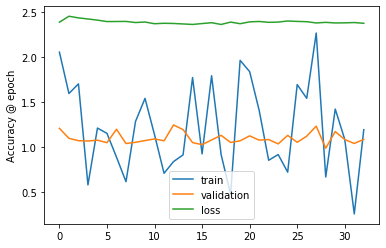

In [2]:
from plot_graphics import plot_history
plot_history(loss_history, train_history, val_history)

# Evaluate model

In [3]:
import torch

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

In [4]:
from dataset import DwgDataset
dwg_dataset = DwgDataset('test_dataset_groups.pickle', batch_size = 4)
dim_features = dwg_dataset.entities.dim_features
ent_features = dwg_dataset.entities.ent_features

In [5]:
from model import DimRnn
model = DimRnn(ent_features, dim_features, 512, device)
#model.to(device)

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
model.load_state_dict(torch.load('DimRnnTrained.model', map_location=device))

model.eval()

RuntimeError: Error(s) in loading state_dict for DimRnn:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([128, 4]) from checkpoint, the shape in current model is torch.Size([512, 4]).
	size mismatch for rnn.weight_hh_l0: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([512, 512]).
	size mismatch for rnn.bias_ih_l0: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for rnn.bias_hh_l0: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for l1.weight: copying a param with shape torch.Size([4, 128]) from checkpoint, the shape in current model is torch.Size([4, 512]).

In [ ]:
import drawSvg as draw
from plot_graphics import draw_sample


In [ ]:
from IPython.display import Image
from IPython.display import clear_output

for j, (_x,_y) in enumerate(dwg_dataset.train_loader):
    out = model(_x)
    for i in range(len(_x)):
        x=_x[i]
        y=_y[i]
        prediction=out[i]
        print(y, prediction)
        graphics = draw_sample(x, y, prediction, verbose=False)
        display(graphics) 
        #clear_output(wait=True)   
    if j>10:
        break
